In [1]:
import torch
import torchvision

In [2]:
n_epochs = 3 #epoch = number of times we go through entire dataset
batch_size_train = 64
batch_size_test = 1000 #batch_size = number of images we go through per step
batch_size_val = 64
learning_rate = 0.01
momentum = 0.5
log_interval = 10
#larger batch sizes 

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed) 

In [19]:
import torch
from PIL import Image
from torchvision.transforms import ToTensor
import json
import numpy as np

class Dataset(torch.utils.data.Dataset):

    def __init__(self, json_path, transform=None):
        'Initialization'
        with open(json_path, 'r') as f:
            data = json.load(f)
        self.labels = list(data.values())
        self.list_IDs = list(data.keys())
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        img_path = 'eccv_18_all_images_sm/' + ID + '.jpg'
        image = Image.open(img_path)
        if image.mode[0] == 'L':
            image = image.convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        X = ToTensor()(image).unsqueeze(0)
        X = X.reshape(3, 28, 28)
        y = self.labels[index]
        label = 1;
        for i in range(len(y['scores'])):
            if(y['scores'][i] > 0.3 and y['tp_fp_labels'][i] == False):
                label = 0;

        return X, label

In [20]:
training_set = Dataset('FPTrainData.json', transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((28, 28)),                              
                             ]))
print(type(training_set))
testing = training_set.__getitem__(127)
print(testing[1])

training_generator = torch.utils.data.DataLoader(training_set, batch_size=batch_size_train, shuffle=True)

type(training_generator)

<class '__main__.Dataset'>
1


torch.utils.data.dataloader.DataLoader

In [21]:
val_set = Dataset('FPValData.json', transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((28, 28)),                              
                             ]))

val_generator = torch.utils.data.DataLoader(val_set, batch_size = batch_size_val, shuffle = True)

In [22]:
testing_set = Dataset('FPTestData.json', transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((28, 28)),                              
                             ]))

testing_generator = torch.utils.data.DataLoader(testing_set, batch_size = batch_size_test, shuffle = True)

In [23]:
examples = enumerate(testing_generator)
batch_idx, (example_data, example_targets) = next(examples)

In [30]:
c = 0

In [31]:
for i in range(len(testing_set)):
    if(testing_set.__getitem__(i)[1] == 0):
        c += 1

c

34

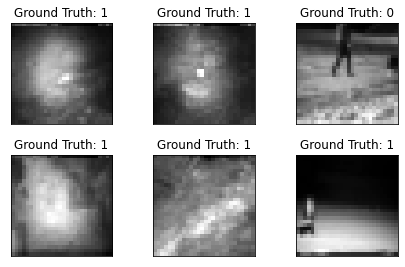

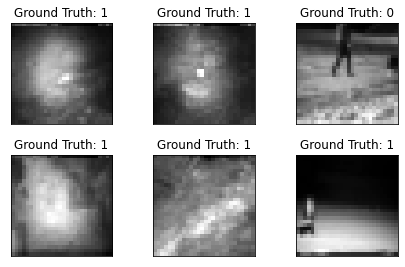

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [12]:
import torch.nn as nn #pytorch module for neural network package 
import torch.nn.functional as F #bunch of losses and non-linearities - needed for good layers
import torch.optim as optim #for optimization

In [13]:
class Net(nn.Module): #setting up network class
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5) #each of these are convolutional layers
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) #kernel_size = how big flashlight is: 5 = 5x5 square - how much of the image we look at a time, stride is how much we move over at a time
        self.conv2_drop = nn.Dropout2d() #try to randomly remove weights and add noise to not overfit to train_data
        self.fc1 = nn.Linear(320, 50) #flattens everything out - fully connected, last piece of neural network and puts it all together
        self.fc2 = nn.Linear(50, 10) #google for pictures

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) #relu function - nonlinearity - with strength of input, scales output - rectified linear unit - without it, linear algebra and only linear transformation
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x) #probabilities - puts out

In [14]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [15]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(training_generator.dataset) for i in range(n_epochs + 1)]

In [16]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(training_generator):
    optimizer.zero_grad() #how we update our weights - anything 0 is not important for next step
    output = network(data) #pass batch into the network and it gives us probabilities 
    loss = F.nll_loss(output, target) #loss function - target: one hot encoding - [0, 0, 1, 0, 0] - targeting 1, nll_loss - score - how close we are to the target
    loss.backward() 
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(training_generator.dataset),
        100. * batch_idx / len(training_generator), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(training_generator.dataset)))
      torch.save(network.state_dict(), 'models.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [17]:
def val():
  network.eval() #freezes drop out weights 
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in val_generator:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(val_generator.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(val_generator.dataset),
    100. * correct / len(val_generator.dataset)))

In [18]:
val()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  val()

C:\Users\snigd\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\snigd\anaconda3\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3287, Accuracy: 0/632 (0%)

Train Epoch: 1 [0/2952 (0%)]	Loss: 2.325131
Train Epoch: 1 [640/2952 (21%)]	Loss: 2.163059
Train Epoch: 1 [1280/2952 (43%)]	Loss: 1.949799
Train Epoch: 1 [1920/2952 (64%)]	Loss: 1.263219
Train Epoch: 1 [2560/2952 (85%)]	Loss: 0.866075

Test set: Avg. loss: 0.6226, Accuracy: 509/632 (81%)

Train Epoch: 2 [0/2952 (0%)]	Loss: 0.962769
Train Epoch: 2 [640/2952 (21%)]	Loss: 0.582380
Train Epoch: 2 [1280/2952 (43%)]	Loss: 0.545718
Train Epoch: 2 [1920/2952 (64%)]	Loss: 0.588957
Train Epoch: 2 [2560/2952 (85%)]	Loss: 0.617538

Test set: Avg. loss: 0.5083, Accuracy: 509/632 (81%)

Train Epoch: 3 [0/2952 (0%)]	Loss: 0.535035
Train Epoch: 3 [640/2952 (21%)]	Loss: 0.447921
Train Epoch: 3 [1280/2952 (43%)]	Loss: 0.559710
Train Epoch: 3 [1920/2952 (64%)]	Loss: 0.590591
Train Epoch: 3 [2560/2952 (85%)]	Loss: 0.651928

Test set: Avg. loss: 0.5038, Accuracy: 509/632 (81%)

